In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))
options(future.globals.maxSize= 891289600 * 160)


# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [ ]:

seurat1=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_1031_mouse/mouse_snrna_all_soupX_fil_batch1_0524.rds')
seurat1$batch='batch1'
#http://localhost:1818/notebooks/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/2文库过滤.ipynb
seurat2=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_1031_mouse/mouse_snrna_all_soupX_fil_batch2_0619.rds')
seurat2$batch='batch2'
#http://localhost:1818/notebooks/spa_seurat/cla/renew_sndata_0619_mouse_mamoset/20230619.cla_snrna/mice/2文库过滤.ipynb
classFiltSeurat=merge(seurat1,seurat2)
classFiltSeurat

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_1031_mouse', "/mouse_snrna_all_soupX_fil300_SCT_0619_0524_anno_SCT.rds"))





In [2]:
readDir='/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_1031_mouse/'
file_name='mouse_snrna_all_soupX_fil300_SCT_0619_0524_anno_SCT.rds'
seurat=readRDS(paste0(readDir,file_name))


Joining, by = "cell"


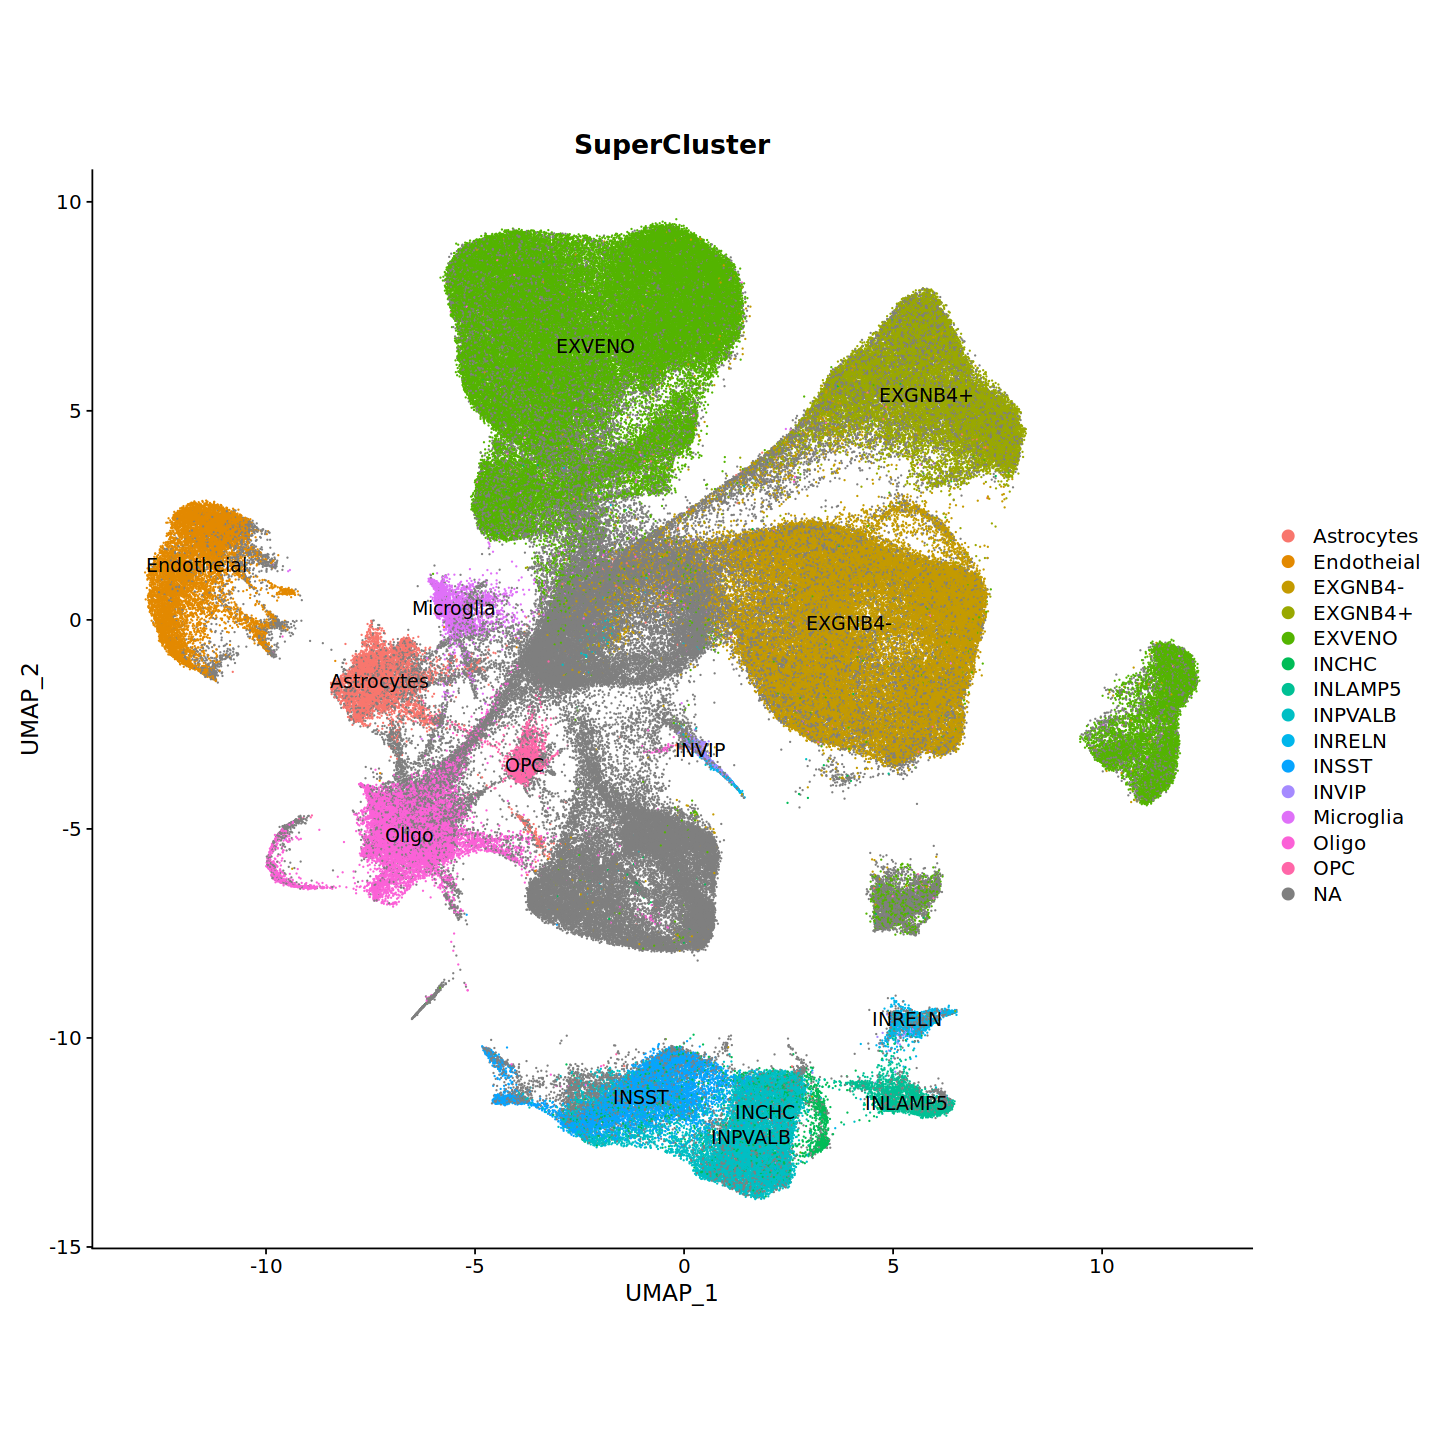

In [8]:
df=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_240115/dif_res_anno/ref_mouse_1.csv')
test=seurat
ref=test@meta.data
ref$cell=rownames(ref)
ref=left_join(ref,df)
test=AddMetaData(test,ref$SuperCluster,col.name = 'SuperCluster')

options(repr.plot.width=12, repr.plot.height=12)
DimPlot(test,group.by = 'SuperCluster',label=T,raster=FALSE)+coord_fixed()


Joining, by = "cell"


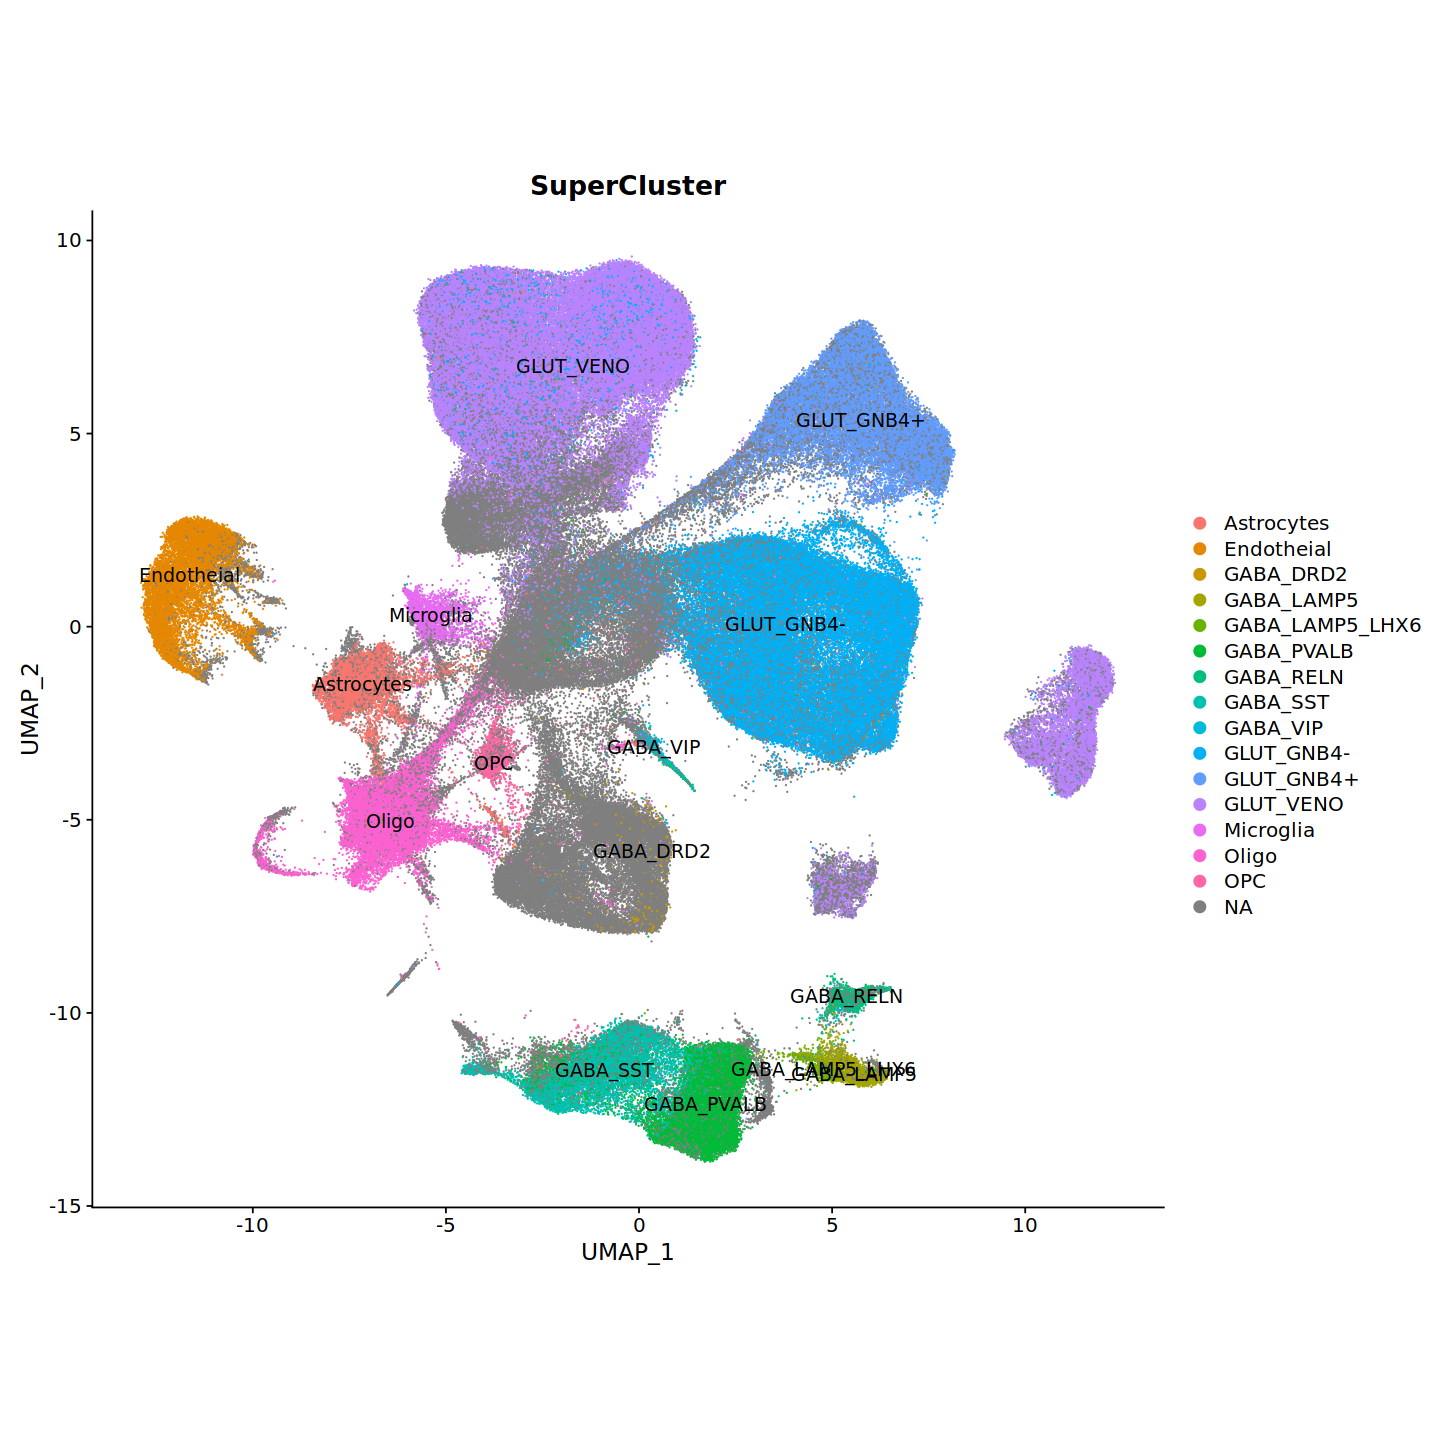

In [3]:
df=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_240115/dif_res_anno/ref_mouse.csv')
test=seurat
ref=test@meta.data
ref$cell=rownames(ref)
ref=left_join(ref,df)
test=AddMetaData(test,ref$SuperCluster,col.name = 'SuperCluster')

options(repr.plot.width=12, repr.plot.height=12)
DimPlot(test,group.by = 'SuperCluster',label=T,raster=FALSE)+coord_fixed()


In [3]:
mouse=seurat
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all", 
    "/屏状核-建库清单.xlsx"
))


libMetaTb=libMetaTb[,c('样本名称','分析样本名称','oligo文库名称')]
colnames(libMetaTb)=c('sample','sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]*')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)
libMetaTb1=libMetaTb

libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla", 
    "/sample_lib_meta.xlsx"
))
libMetaTb=libMetaTb[,c('jobid','tissue','sampleID')]
colnames(libMetaTb)=c('sample','sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)
libMetaTb2=libMetaTb

libMetaTb=rbind(libMetaTb1,libMetaTb2)

ref=mouse@meta.data[,'group',drop=F]
ref$cell=rownames(ref)
libMetaTb$group=libMetaTb$libId
ref=left_join(ref,libMetaTb)
ref=ref[!duplicated(ref),]

mouse=AddMetaData(mouse,col.name = 'sample',ref$sample)


sample     sampleId   libId 
1 MS-cla-001 MS-cla-001 2191-1
2 MS-cla-001 MS-cla-001 2191-2
3 MS-cla-001 MS-cla-001 2191-3
4 MS-cla-001 MS-cla-001 2191-4
5 MS-cla-001 MS-cla-001 2191-5
6 MS-cla-001 MS-cla-001 2191-6

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`


sample      sampleId    libId 
1 MQC286R-cla Cla-rostral 6103-1
2 MQC286R-cla Cla-rostral 6103-2
3 MQC286R-cla Cla-rostral 6103-3
4 MQC286R-cla Cla-rostral 6103-4
5 MQC286R-cla Cla-rostral 6103-5
6 MQC286R-cla Cla-rostral 6103-6

Joining, by = "group"


In [7]:
mouse

An object of class Seurat 
91564 features across 326910 samples within 2 assays 
Active assay: SCT (42856 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [5]:
table(mouse$sample)


   MS-cla-001 MS060-cla 001  MS060-cla001 
        76521        131543        118846 

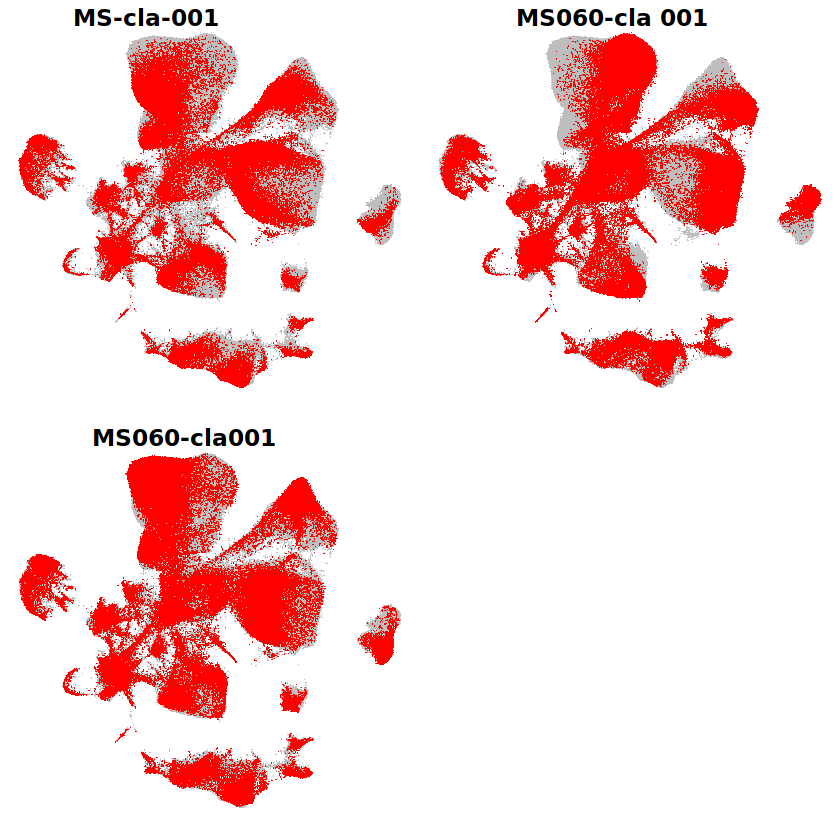

In [6]:
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(mouse, highlightBy="sample", showAllPoints=T, size=0.1)
                   

In [8]:
seurat=mouse  

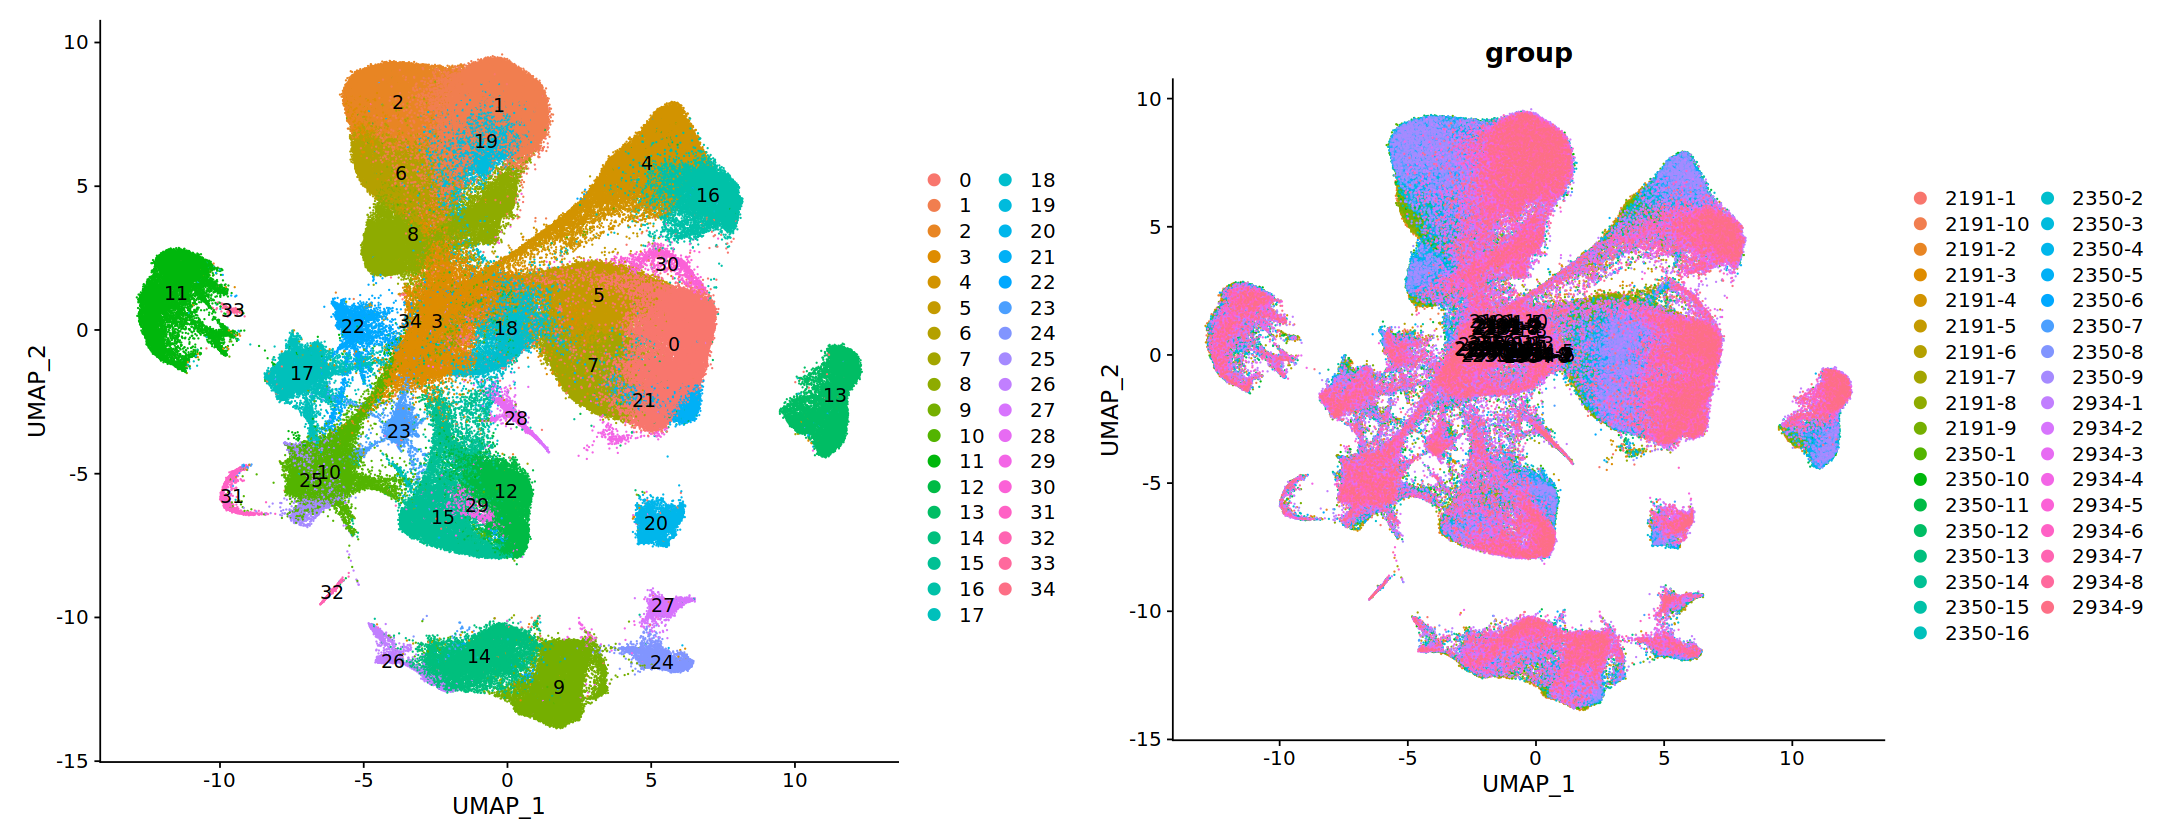

In [9]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed(),
    #DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="group", label=T,raster=FALSE)+coord_fixed(),
    nrow=1
)

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: Dlx6-As1, Zmydn10, Alpha-Sma, Pdgfralpha, Vecad, Cd105, Cox4l2, Motch3, Cs3cr1”


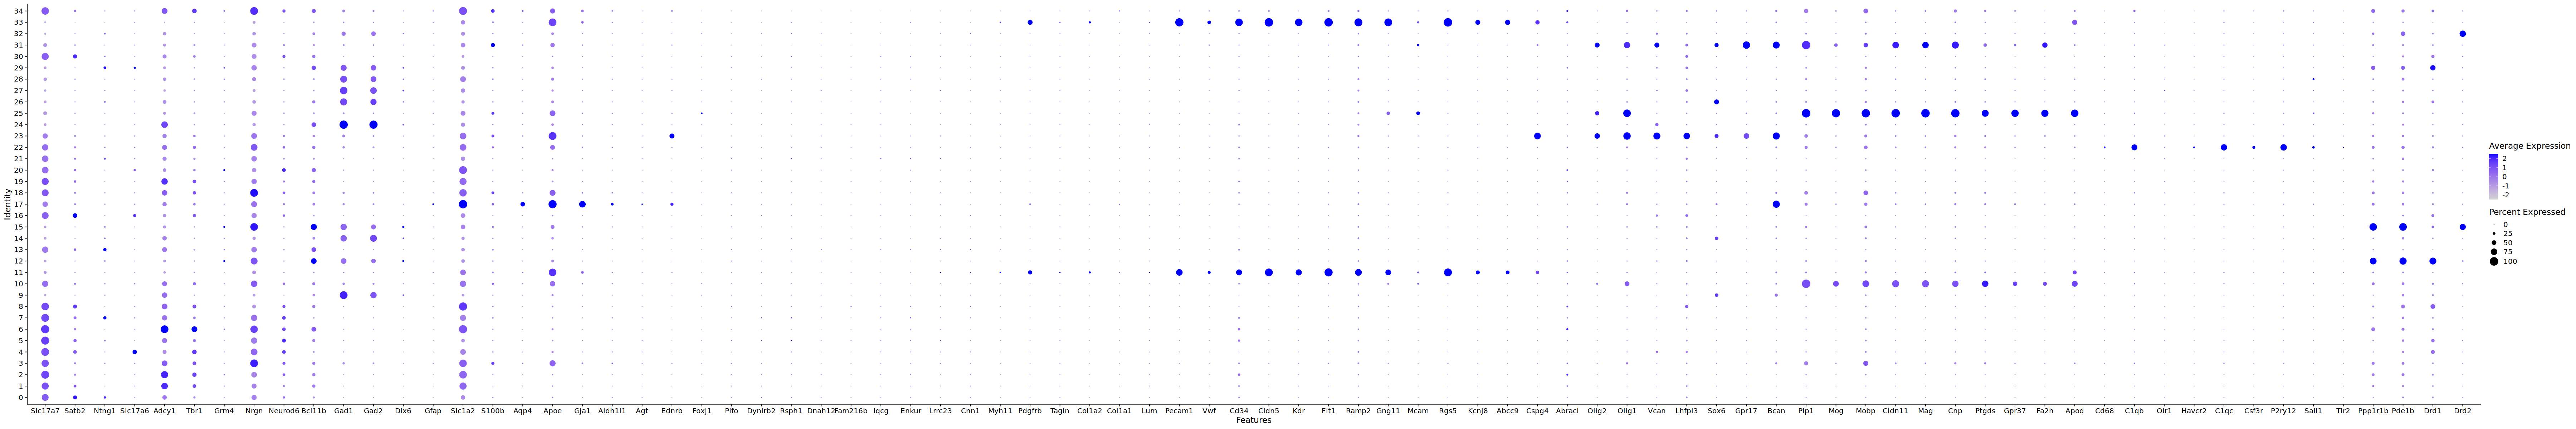

In [17]:


selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2',# Microglia
    'PPP1R1B','BCL11B','PDE1B','DRD1','DRD2'
)



selectMarkers=str_to_title(selectMarkers)

selectMarkers=selectMarkers[!duplicated(selectMarkers)]
Idents(seurat) = "seurat_clusters"
options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)




In [24]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,1,2,4,5,6,7,8,13,16,19,20,30),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(9,14,24,26,27),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(17),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(10,25),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(11,33),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(23),]$class='OPC'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(22),]$class='Microglia'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(12,15,32),]$class='MSN'


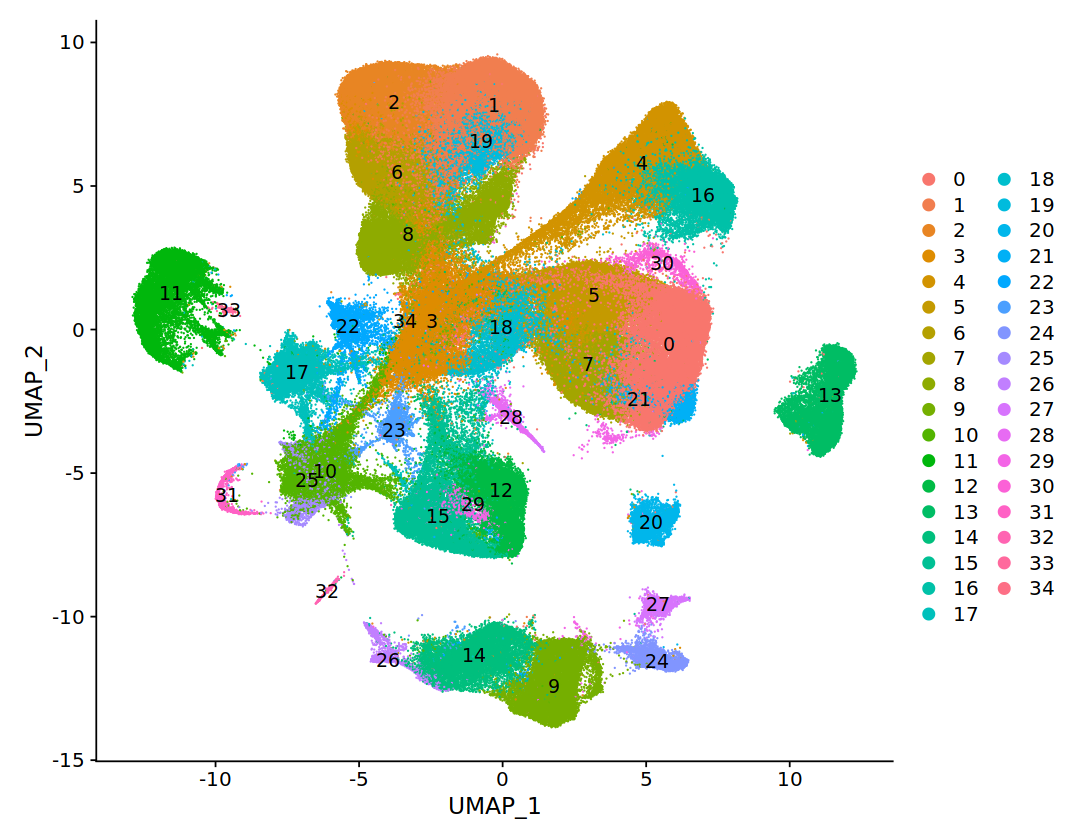

In [25]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')


Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()


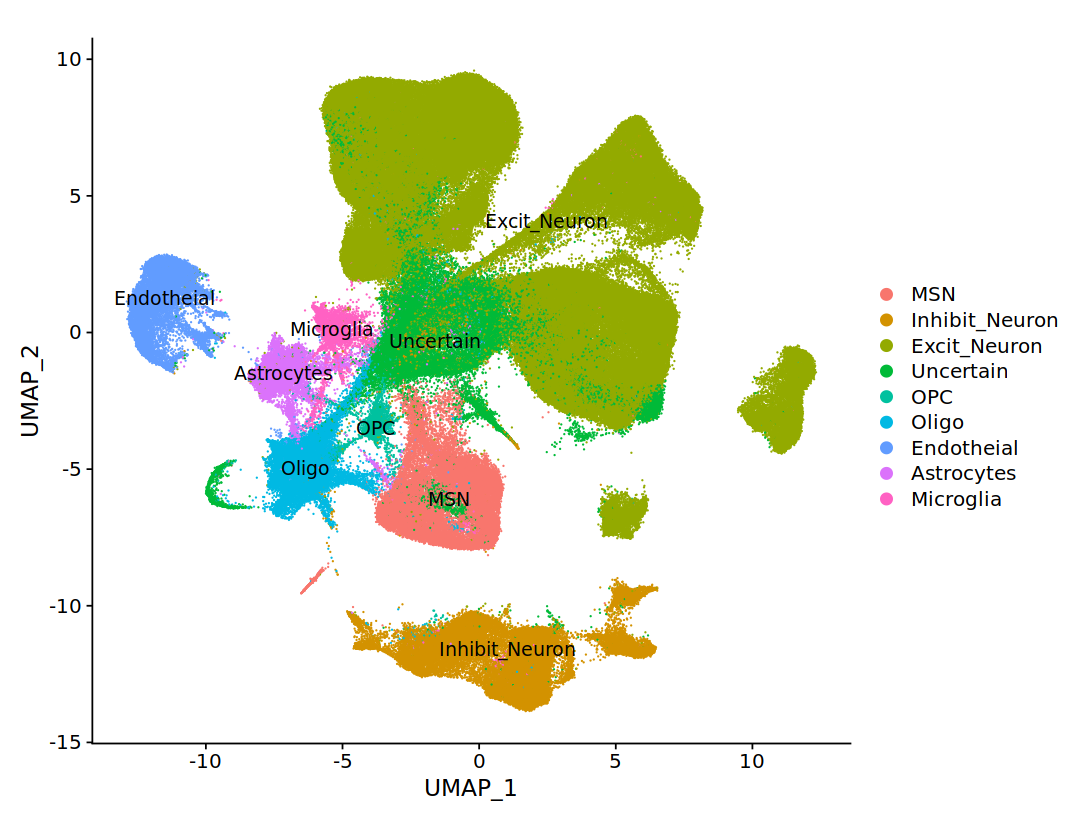

In [26]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

In [28]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	40724 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           5000           5000           5000           3200 
           MSN          Oligo            OPC      Uncertain 
          5000           5000           2524           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           5000           5000           5000           3200 
           MSN          Oligo            OPC      Uncertain 
          5000           5000           2524           5000 

In [29]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))


Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Microglia

Calculating cluster MSN

Calculating cluster Oligo

Calculating cluster OPC

Calculating cluster Uncertain




    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            36            169              6             26             15 
           MSN          Oligo            OPC      Uncertain 
            56             28             19              8 

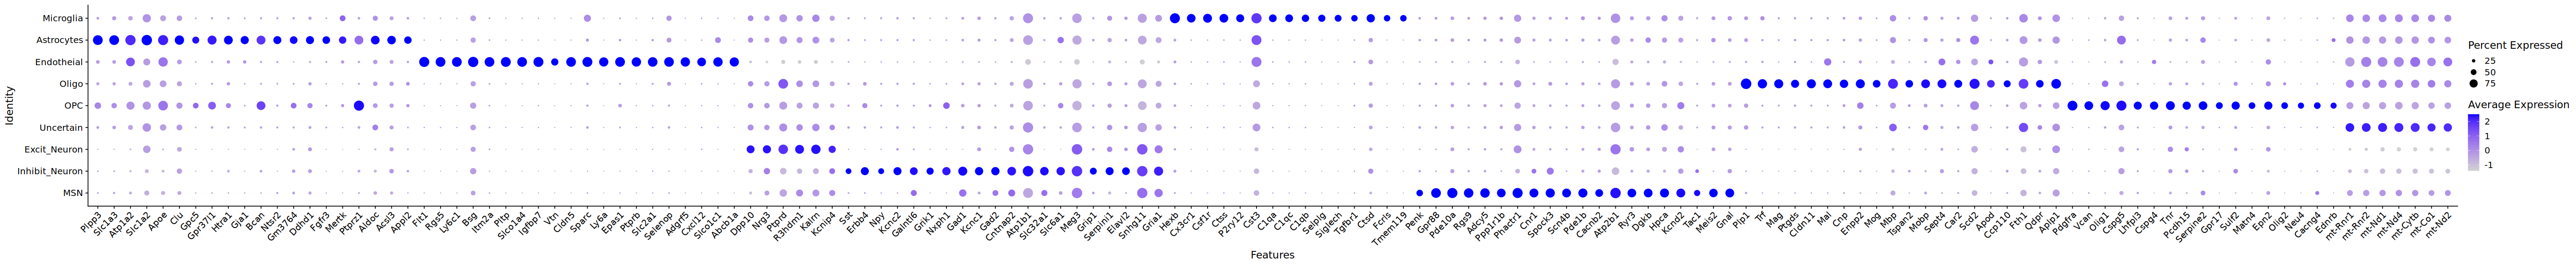

In [30]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()


 num [1:8, 1:9] 4859 35 28 43 16 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:9] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


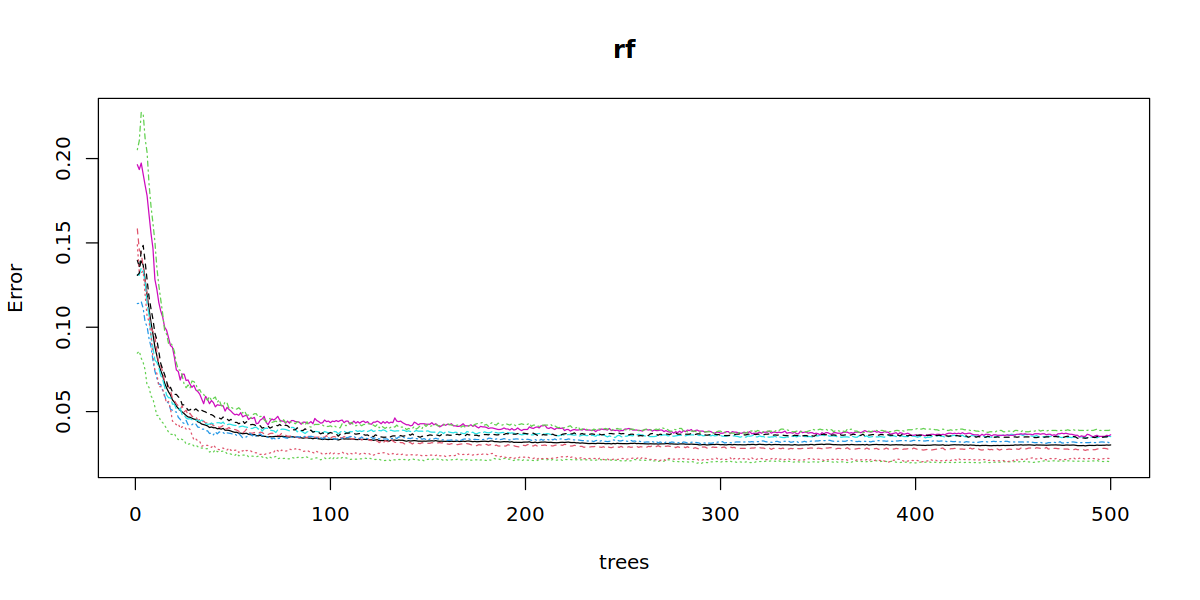

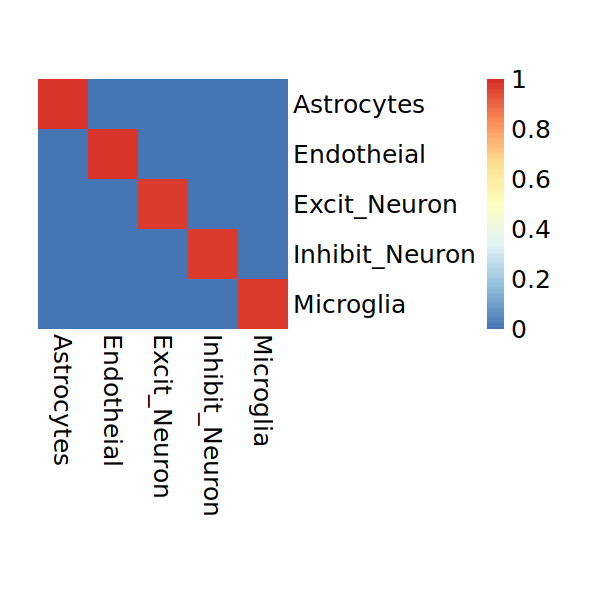

In [31]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:5, 1:5], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:326910, 1:8] 0.004 0 0.004 0.004 0.036 0.064 0.006 0.002 0.008 0.014 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:326910] "2191-1_CELL6894_N1" "2191-1_CELL2974_N1" "2191-1_CELL39_N2" "2191-1_CELL4337_N1" ...
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId             maxPredClassScore maxPredClass  
1 2191-1_CELL6894_N1 0.842             MSN           
2 2191-1_CELL2974_N1 0.998             Inhibit_Neuron
3 2191-1_CELL39_N2   0.980             Excit_Neuron  
4 2191-1_CELL4337_N1 0.968             Excit_Neuron  
5 2191-1_CELL4465_N1 0.944             Inhibit_Neuron
6 2191-1_CELL2955_N1 0.824             Excit_Neuron

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1460  0.7800  0.9320  0.8443  0.9800  1.0000 

[1] TRUE

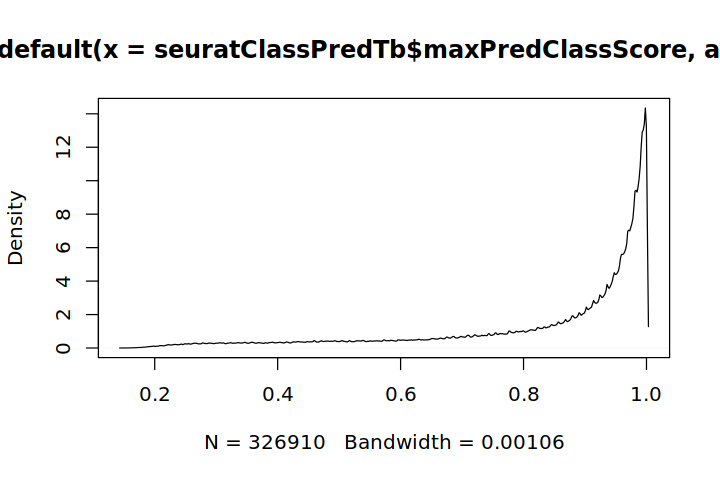

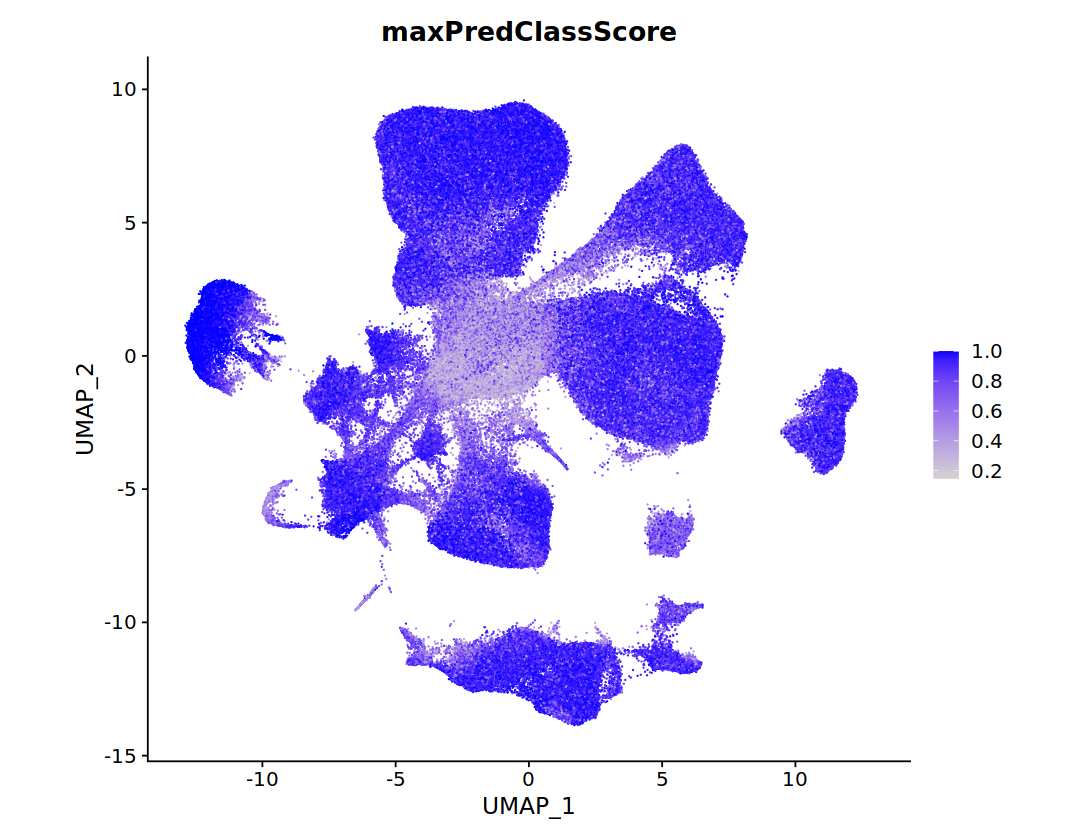

In [32]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


In [35]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)


Filt cell ratio: 0.731849744578018



In [36]:
classFiltSeurat

An object of class Seurat 
91564 features across 239249 samples within 2 assays 
Active assay: SCT (42856 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [37]:
#EXIN按照nfeature800过滤
df_fil=classFiltSeurat@meta.data
EX_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Excit_Neuron',])
IN_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Inhibit_Neuron',])
Other_cell=rownames(df_fil[df_fil$maxPredClass %in% setdiff(unique(df_fil$maxPredClass),c('Excit_Neuron','Inhibit_Neuron')),])
fil_cell=c(EX_cell,IN_cell,Other_cell)

classFiltSeurat=subset(classFiltSeurat,cells = fil_cell)

classFiltSeurat

An object of class Seurat 
91564 features across 239051 samples within 2 assays 
Active assay: SCT (42856 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [40]:
print(1)

[1] 1


In [38]:
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_240115/mouse_snrna_all_soupX_fil300_800_anno_SCT_RFfil_240116.rds')



In [6]:
classFiltSeurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_240115/mouse_snrna_all_soupX_fil300_800_anno_SCT_RFfil_240116.rds')



Joining, by = "cell"


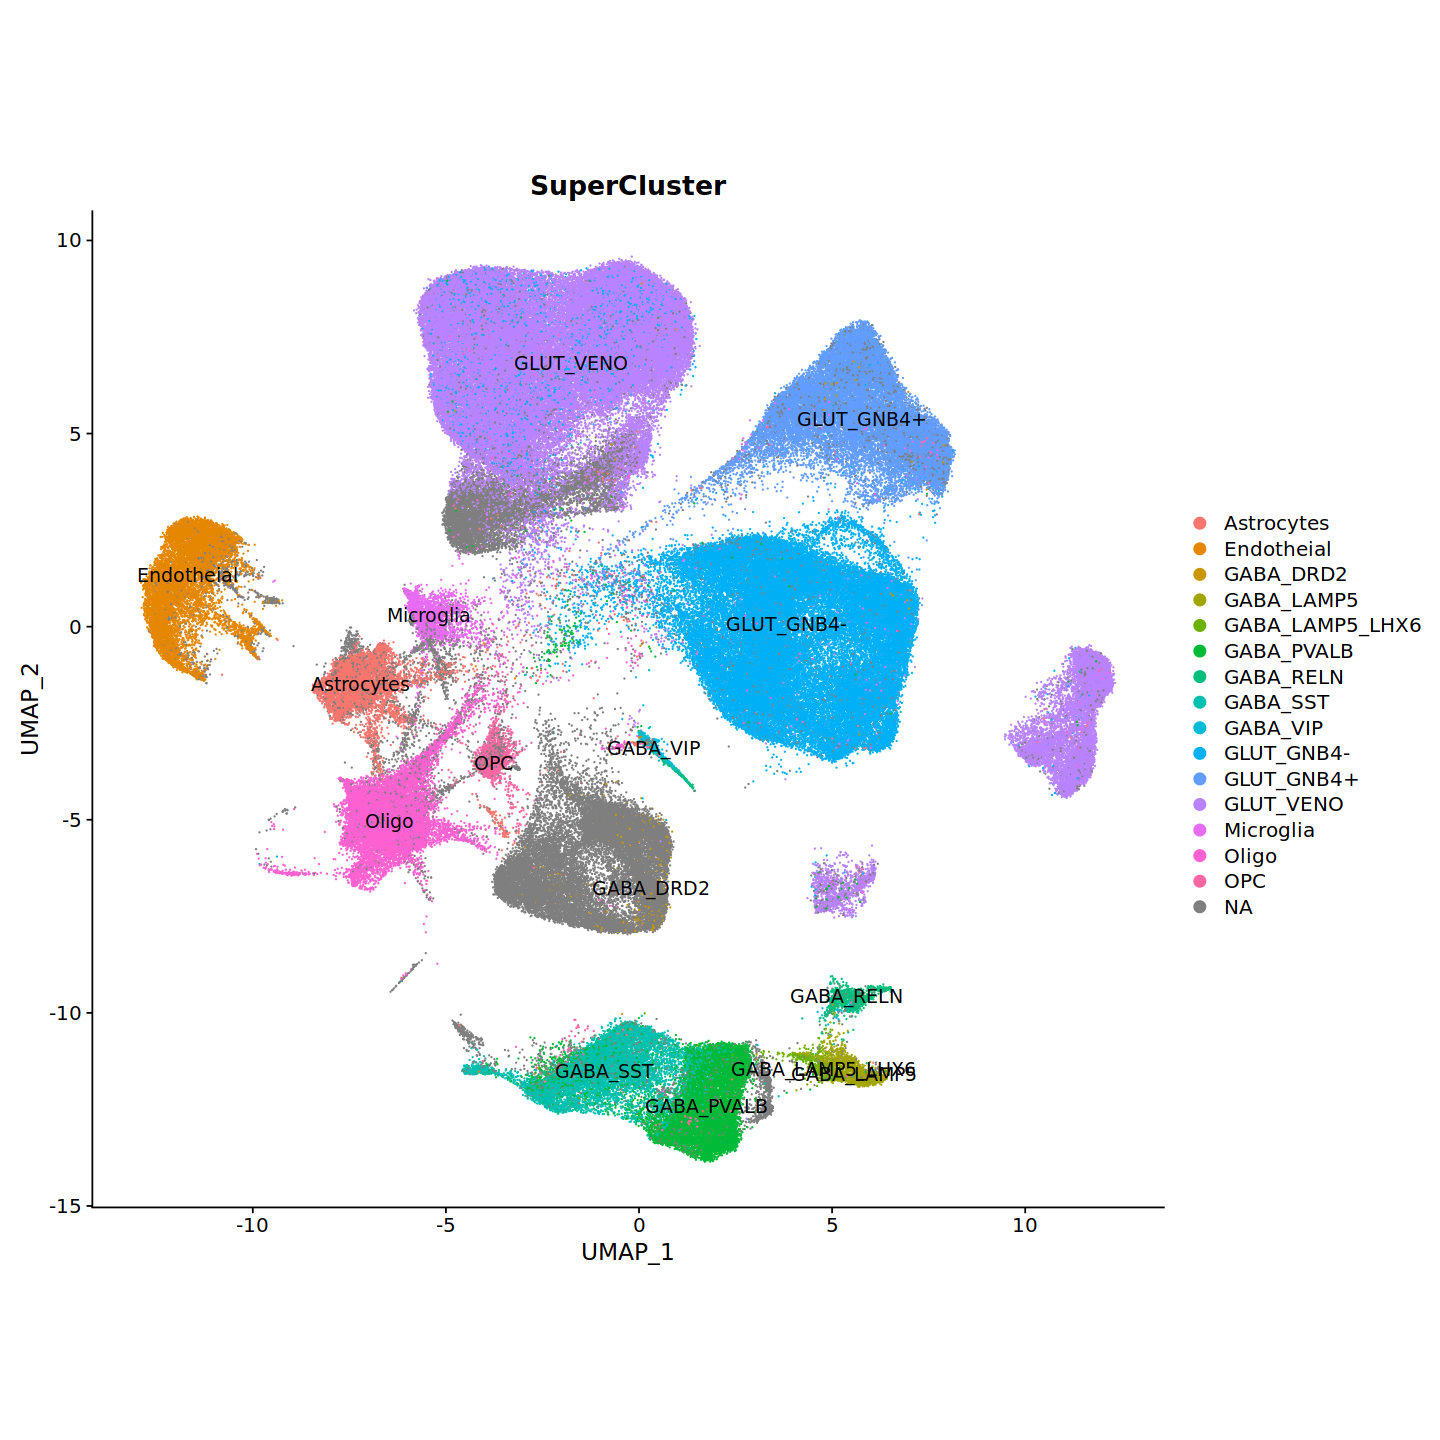

In [7]:
df=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_240115/dif_res_anno/ref_mouse.csv')
test=classFiltSeurat
ref=test@meta.data
ref$cell=rownames(ref)
ref=left_join(ref,df)
test=AddMetaData(test,ref$SuperCluster,col.name = 'SuperCluster')

options(repr.plot.width=12, repr.plot.height=12)
DimPlot(test,group.by = 'SuperCluster',label=T,raster=FALSE)+coord_fixed()


In [ ]:


Excit=subset(classFiltSeurat,maxPredClass=='Excit_Neuron')
Inhibit=subset(classFiltSeurat,maxPredClass=='Inhibit_Neuron')
Astrocytes=subset(classFiltSeurat,maxPredClass=='Astrocytes')
Oligo=subset(classFiltSeurat,maxPredClass=='Oligo')
Microglia=subset(classFiltSeurat,maxPredClass=='Microglia')
OPC=subset(classFiltSeurat,maxPredClass=='OPC')
#MSN=subset(classFiltSeurat,maxPredClass=='MSN')
#VLMC=subset(classFiltSeurat,maxPredClass=='VLMC')
Endotheial=subset(classFiltSeurat,maxPredClass=='Endotheial')
